# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('../DEA/' + cell_type):
        os.makedirs('../DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)
    
    expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [8]:
def run_MAST_for_celltype_condition(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST_condition.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file )
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_exci = sc.read_h5ad(outdir+'adata_high_var_excitatory_clusters.h5ad')

# Subset Exci Neurons Brainstem & Input original Adata

In [89]:
adata_exci_BS = adata_exci.copy()
adata_exci_BS = adata_exci_BS[adata_exci_BS.obs['B_region'].isin(['BrainStem']),:]
adata_exci_BS.shape

(816, 17054)

In [90]:
adata_exci_BS.obs.Condition.value_counts()

VE         588
Control    228
Name: Condition, dtype: int64

In [91]:
broad_clusters = adata_exci_BS.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_exci_BS.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 228})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 588})


In [92]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


,Sample ID,Condition
cell_barcodes,,
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control


In [93]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [94]:
adata_exci_BS = adata[adata_exci_BS.obs.index, :]
adata_exci_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(816, 22292)

# Pre-processing

## QC

In [95]:
adata_exci_BS, mito_genes, RB_genes_in_data = qc_metrics(adata_exci_BS)
markers = []
if type(adata_exci_BS.X)==np.ndarray:
    pass
else:
    print(type(adata_exci_BS.X))
    #print(adata_norm.X.shape)
    adata_exci_BS.X = adata_exci_BS.X.toarray()
    #print(adata_norm.X.shape)
adata_exci_BS.X = pd.DataFrame(data=adata_exci_BS.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [96]:
adata_exci_BS.shape

(816, 22292)

## Normalization

In [97]:
markers = []
adata_exci_BS, markers = norm_filter(adata_exci_BS, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_exci_BS.obs.head()

(816, 22292)
(816, 13393)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(816, 13215)
(816, 13203)
True
Im here2


Trying to set attribute `.uns` of view, copying.


1999
1999


,Sample ID,Condition,B_region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,original_total_counts,log10_original_total_counts
cell_barcodes,,,,,,,,,,,,,,,,,,,
241109220878579_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,BrainStem,6512,8.781555,29838.0,10.303572,18.613848,25.246330,33.779074,48.297473,93.0,4.543295,0.311683,204.0,5.323010,0.683692,29838.0,4.474770
164750311669165_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,BrainStem,3105,8.041091,6582.0,8.792246,16.788210,23.154057,31.844424,47.705864,86.0,4.465908,1.306594,61.0,4.127134,0.926770,6582.0,3.818358
129998551411934_1820_C1029_Ctrl_ES_BS_IGO_10856_3,1820_C1029_Ctrl_ES_BS_IGO_10856_3,Control,BrainStem,3225,8.078998,8390.0,9.034915,21.942789,29.070322,38.009535,53.742551,7.0,2.079442,0.083433,56.0,4.043051,0.667461,8390.0,3.923762
230677806771619_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,BrainStem,2801,7.938089,7550.0,8.929436,24.966887,33.337748,43.735099,59.854305,22.0,3.135494,0.291391,32.0,3.496508,0.423841,7550.0,3.877947
231289958288748_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,BrainStem,1201,7.091742,1828.0,7.511525,21.170678,29.978118,41.301969,61.652079,0.0,0.000000,0.000000,23.0,3.178054,1.258206,1828.0,3.261976


## PCA

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[[3.2130592 0.        1.6174334 ... 0.        1.6174334 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [2.271123  0.        2.271123  ... 0.        0.        0.       ]]
(816, 13203)
(816, 13203)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


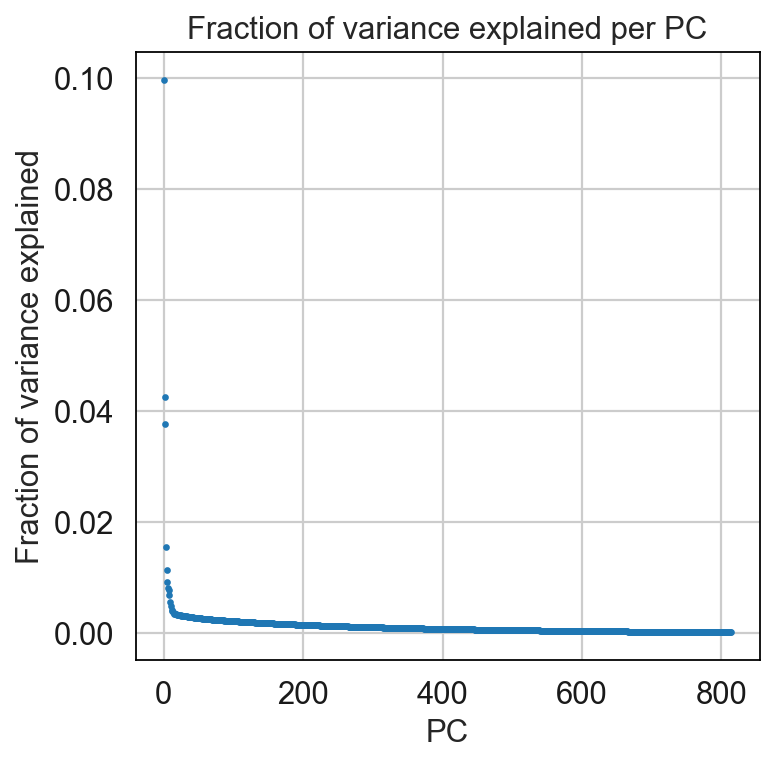

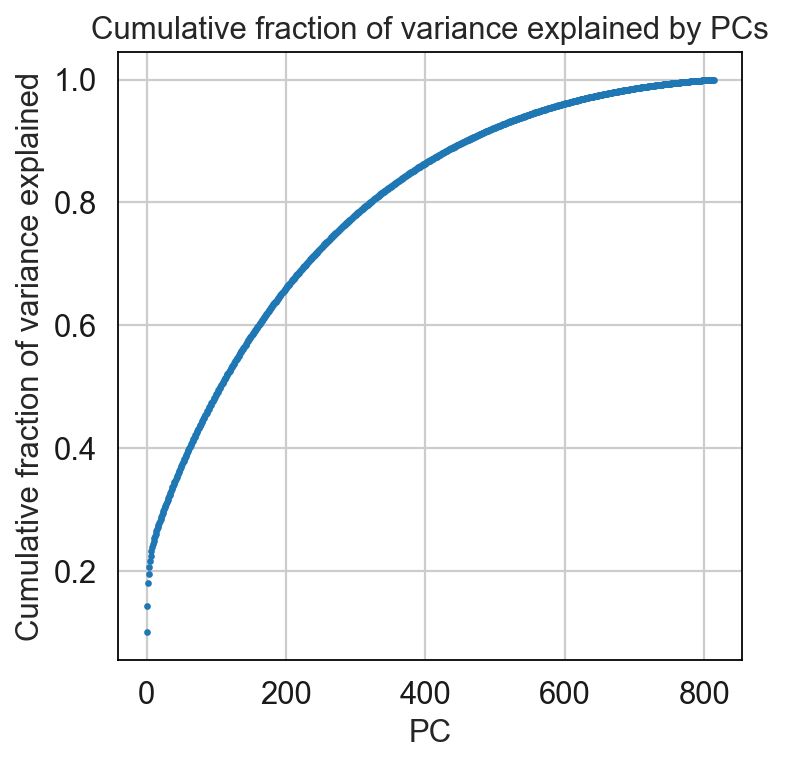

Knee point: 14
Explained variance: 0.26420587


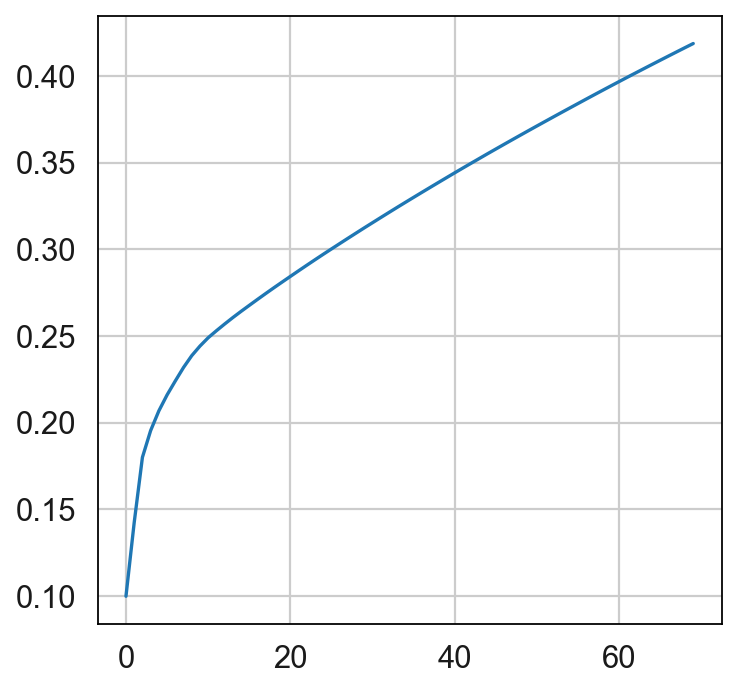

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


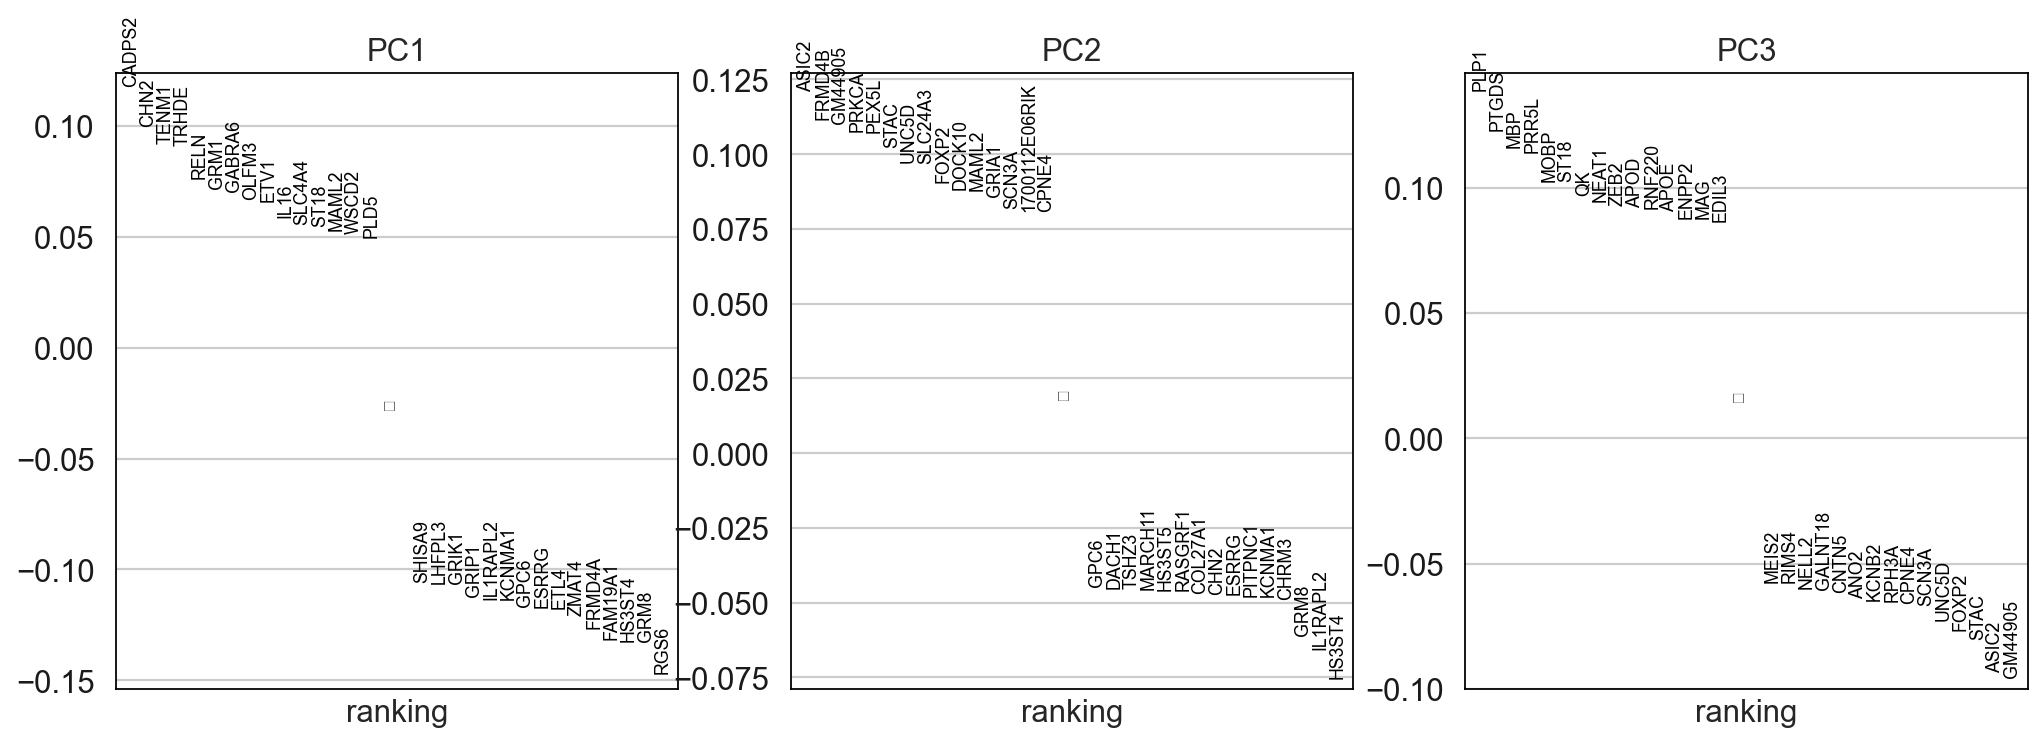

(816, 13203)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [98]:
sc.set_figure_params(figsize=(5, 5))
adata_exci_BS = run_pca_knee(adata_exci_BS)#, 0.5)
adata_exci_BS.obs['PC 1'] = adata_exci_BS.obsm['X_pca'][:,0] # optional
adata_exci_BS.obs['PC 2'] = adata_exci_BS.obsm['X_pca'][:,1]
adata_exci_BS.obs['PC 3'] = adata_exci_BS.obsm['X_pca'][:,2]

print(adata_exci_BS.shape)
adata_exci_BS.X = pd.DataFrame(adata_exci_BS.X).fillna(0).values
index_list = np.arange(adata_exci_BS.shape[0])
np.random.shuffle(index_list)
adata_exci_BS = adata_exci_BS[index_list,:]

In [99]:
print(adata_exci_BS.shape)
adata_exci_BS.X = pd.DataFrame(adata_exci_BS.X).fillna(0).values
index_list = np.arange(adata_exci_BS.shape[0])
np.random.shuffle(index_list)
adata_exci_BS = adata_exci_BS[index_list,:]

(816, 13203)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.012330055236816406 seconds
Jaccard graph constructed in 1.457913875579834 seconds
Wrote graph to binary file in 0.014174938201904297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.88191
Louvain completed 21 runs in 0.3683900833129883 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.9634408950805664 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.012861013412475586 seconds
Jaccard graph constructed in 1.0718870162963867 seconds
Wrote graph to binary file in 0.020392179489135742 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.861559
After 16 runs, maximum modularity is Q = 0.862709
Louvain completed 36 runs in 0.5910589694976807 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.3765311241149902 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.013033866882324219 seconds
Jaccard graph constructed in 0.8452208042144775 seconds
Wrote graph to binary file in 0.030372142791748047 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.844563
After 3 runs, maximum modularity is Q = 0.846038
Louvain completed 23 runs in 0.4946901798248291 seconds
Sorting communities by size, please wa

Text(0.5, 0, 'k')

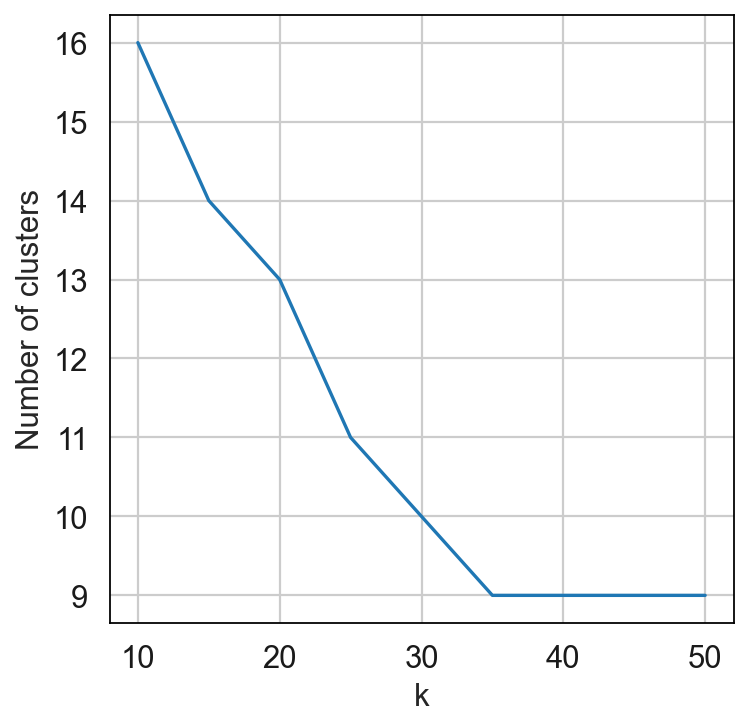

In [100]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_exci_BS.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_exci_BS.obs['PhenoGraph_clusters_exci_BS'+str(k)] = pd.Categorical(communities)
    adata_exci_BS.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_exci_BS.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [101]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_exci_BS.obs['PhenoGraph_clusters_exci_BS'+str(k_list[run1])].values,
            adata_exci_BS.obs['PhenoGraph_clusters_exci_BS'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

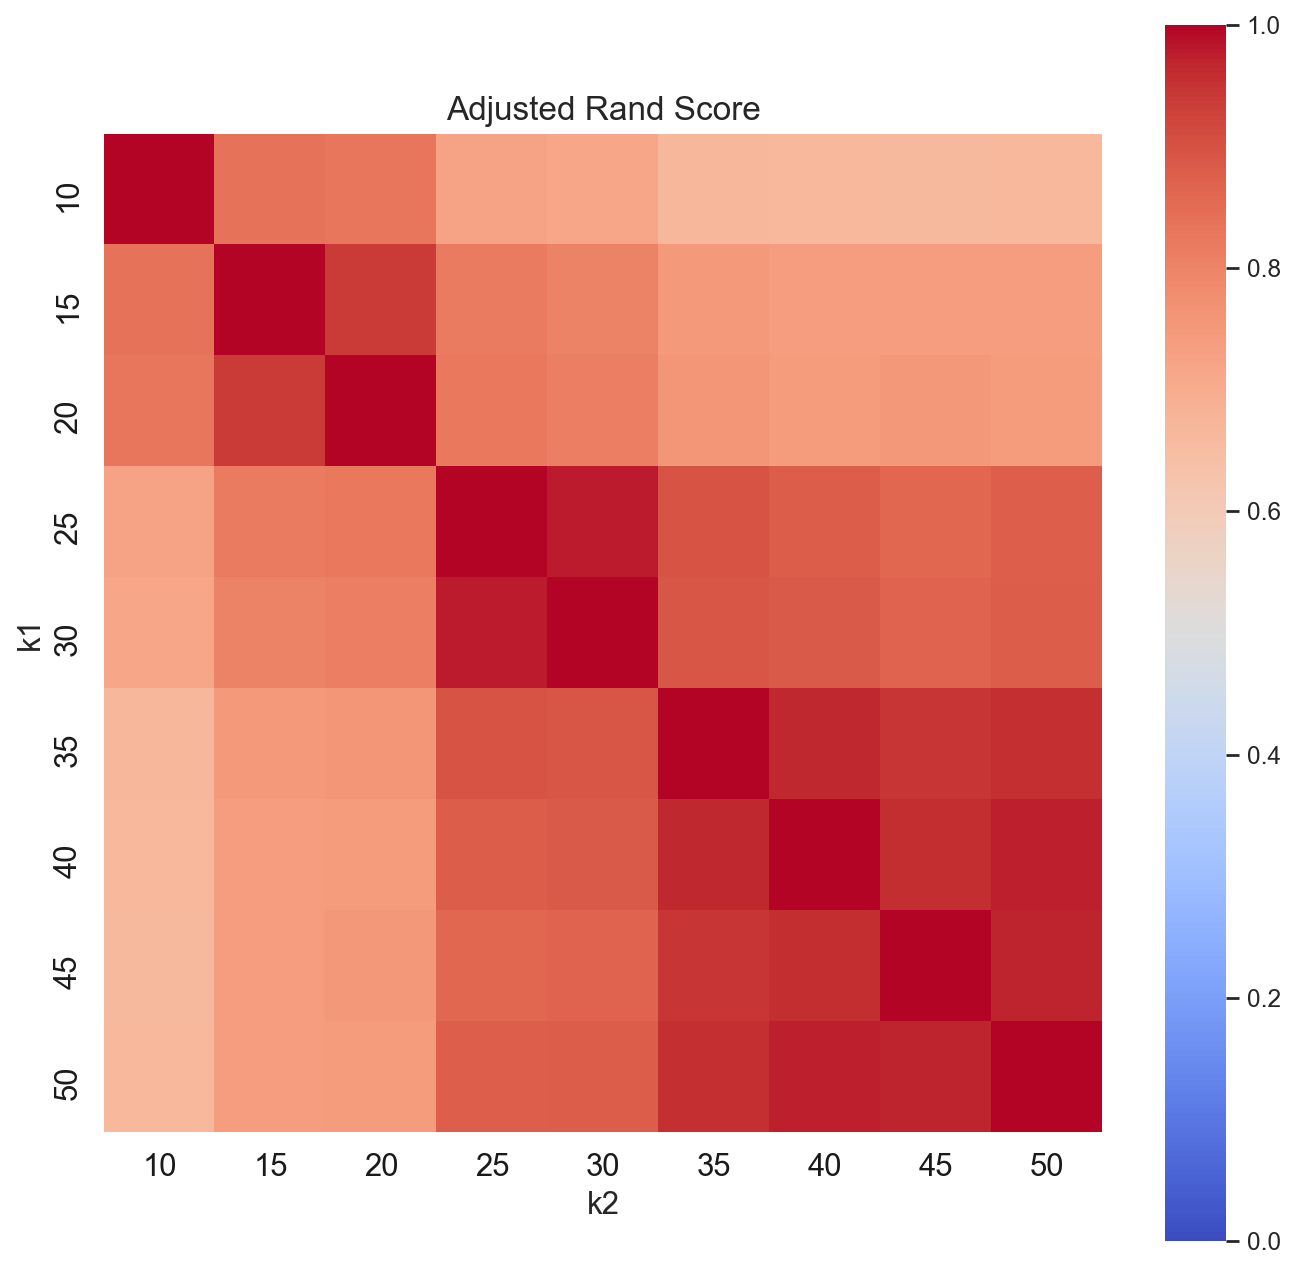

In [102]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [103]:
k = 40 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_exci_BS.obsm['X_pca']),k=k) # run PhenoGraph
adata_exci_BS.obs['PhenoGraph_clusters_exci_BS'] = pd.Categorical(communities)
adata_exci_BS.uns['PhenoGraph_Q'] = Q
adata_exci_BS.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.015285015106201172 seconds
Jaccard graph constructed in 0.9398829936981201 seconds
Wrote graph to binary file in 0.050772905349731445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.811235
After 2 runs, maximum modularity is Q = 0.81235
Louvain completed 22 runs in 0.43556714057922363 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.0930469036102295 seconds


# Vizualization & Markers

## Vizualize Excitatory BS sub-clusters

In [104]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_exci_BS, method='umap', use_rep='X_pca')
sc.tl.umap(adata_exci_BS, random_state=None)

... storing 'Condition' as categorical
... storing 'B_region' as categorical


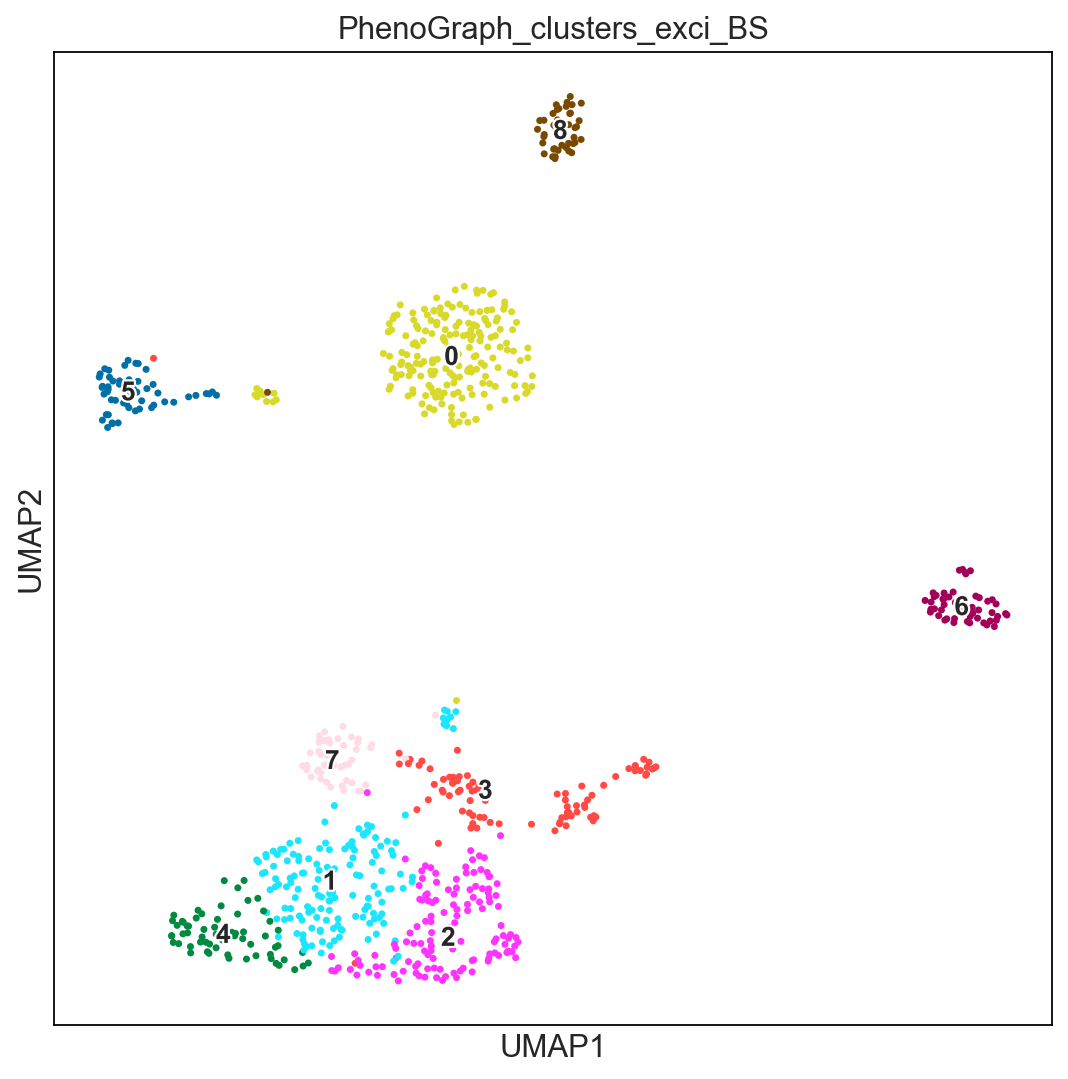

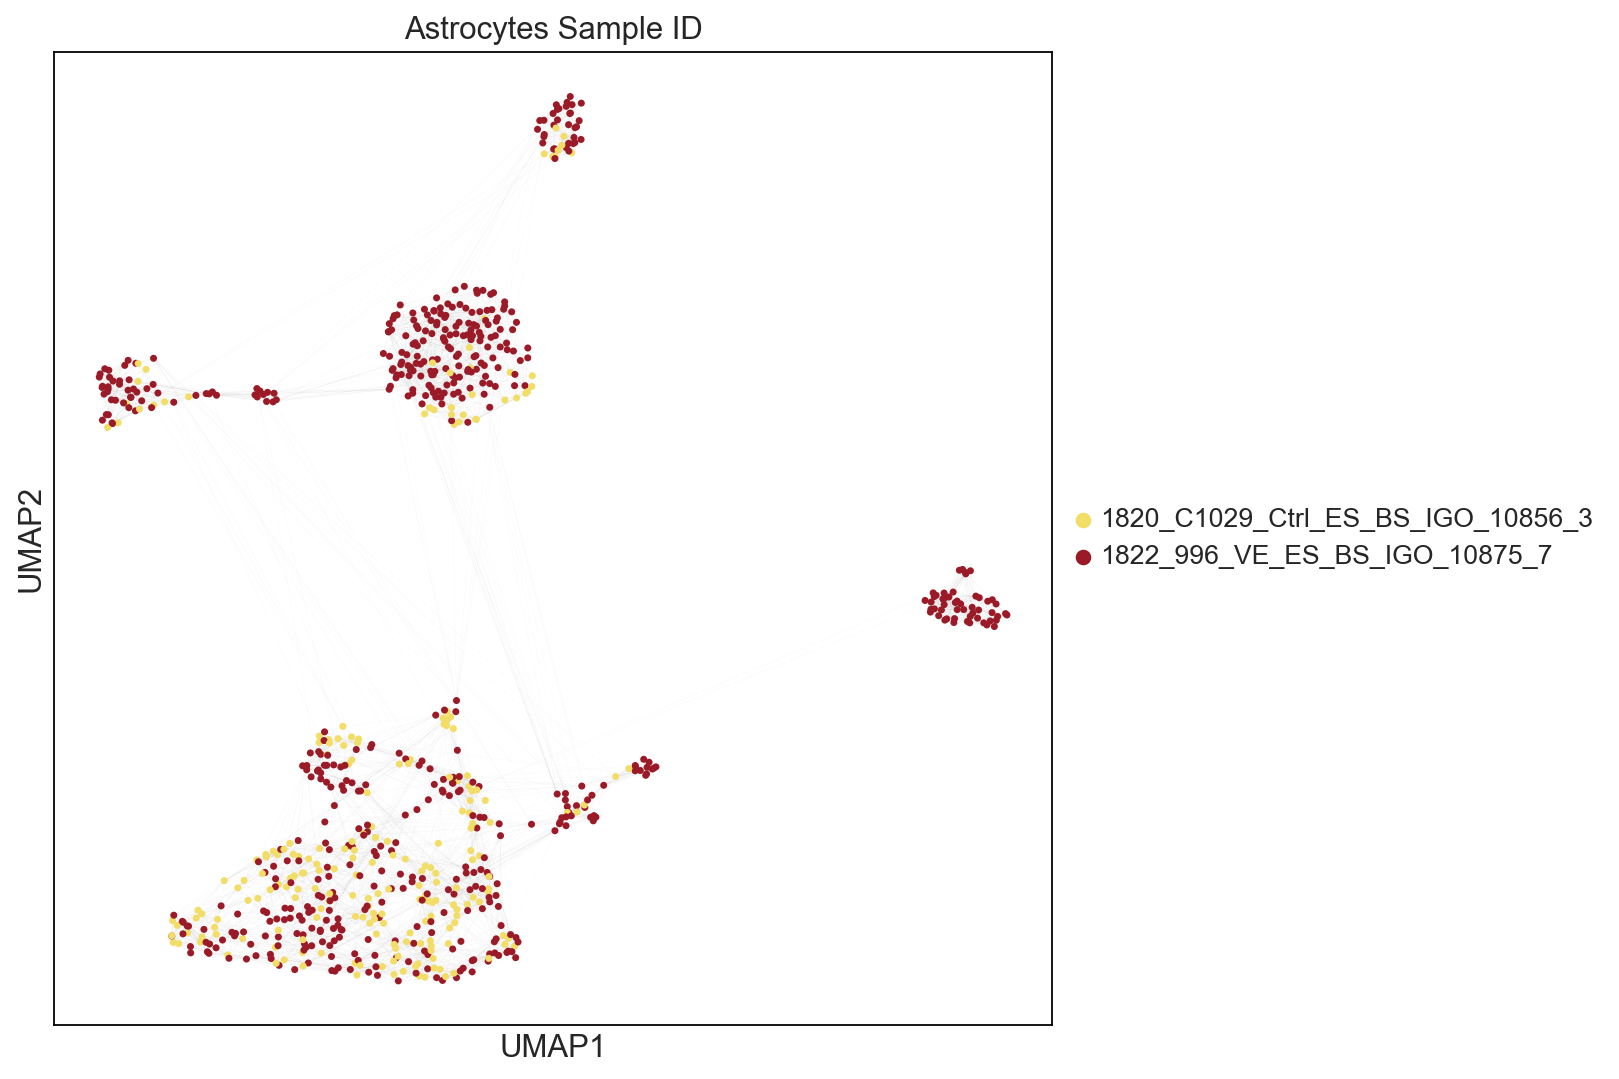

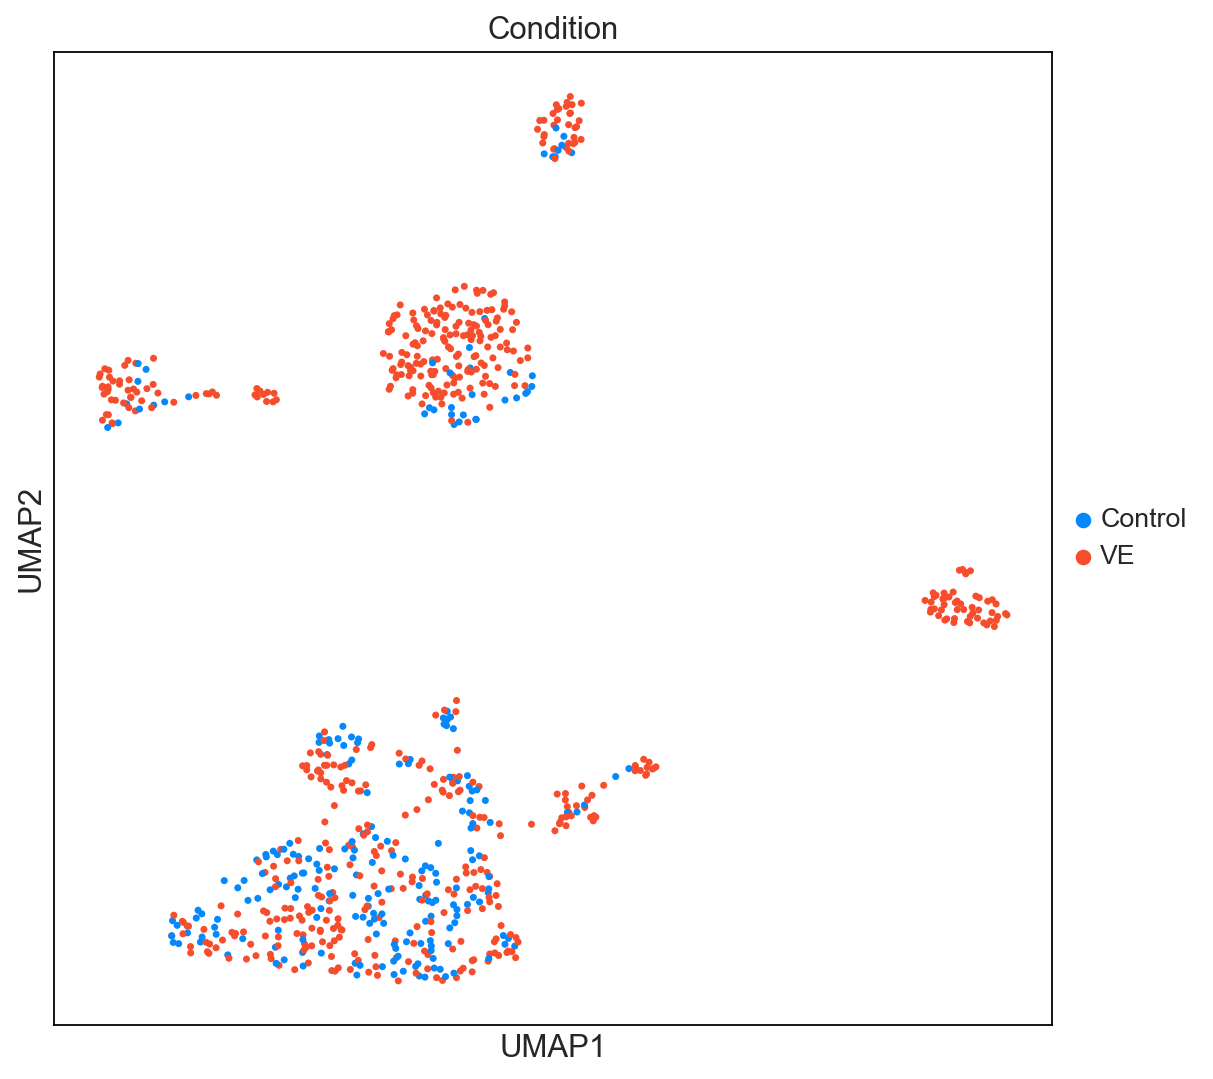

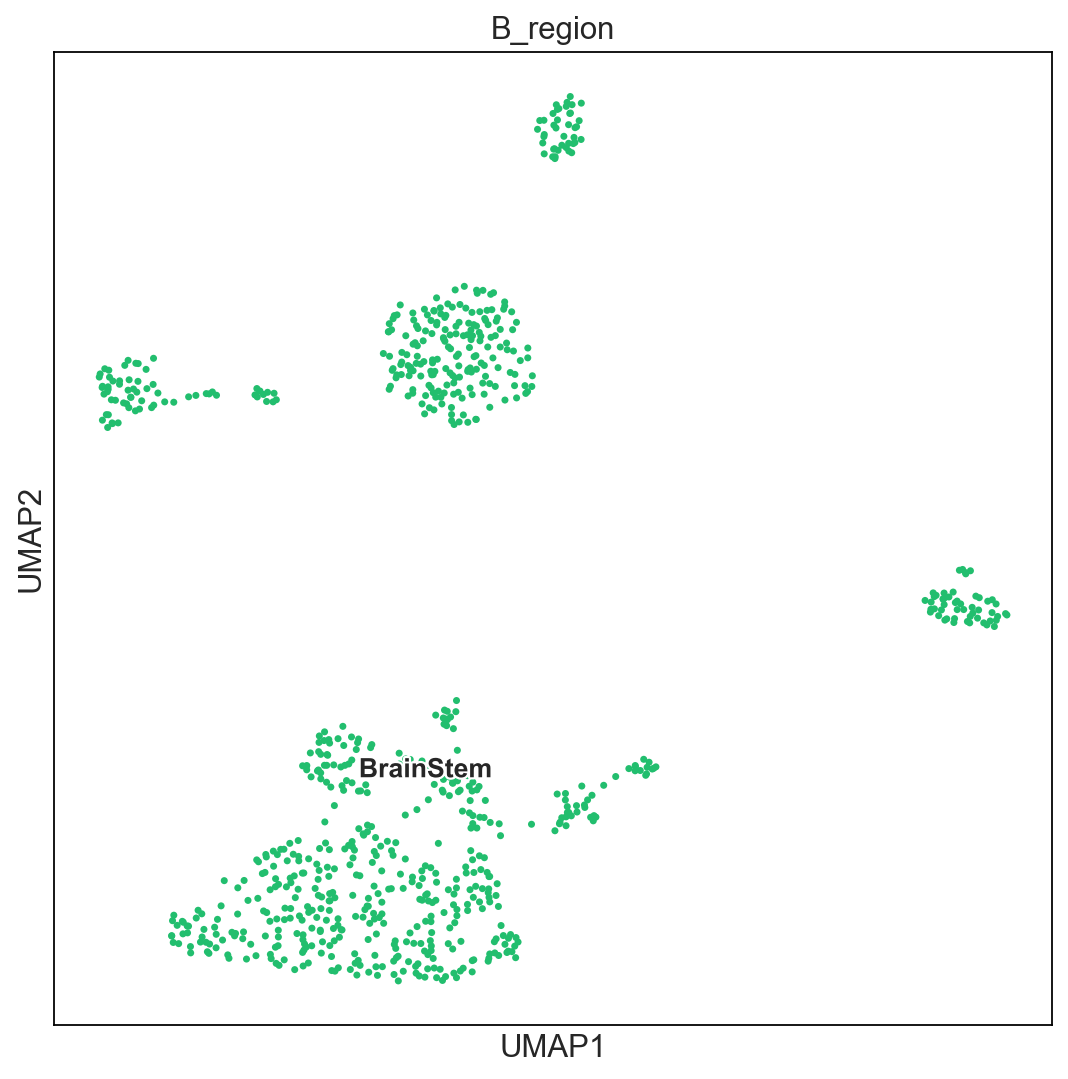

In [105]:
sc.pl.umap(adata_exci_BS,
           color=['PhenoGraph_clusters_exci_BS'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2,)

sc.pl.umap(adata_exci_BS, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_exci_BS,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)

sc.pl.umap(adata_exci_BS,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [106]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Exci_BS_0',
    1 : 'Exci_BS_1',
    2 : 'Exci_BS_2',
    3 : 'Exci_BS_3',
    4 : 'Exci_BS_4',
    5 : 'Exci_BS_5',
    6 : 'Exci_BS_6',
    7 : 'Exci_BS_7',
    8 : 'Exci_BS_8'}

adata_exci_BS.obs['PhenoGraph_clusters_exci_BS_str'] = adata_exci_BS.obs['PhenoGraph_clusters_exci_BS'].map(cl_int_to_str).astype('category')

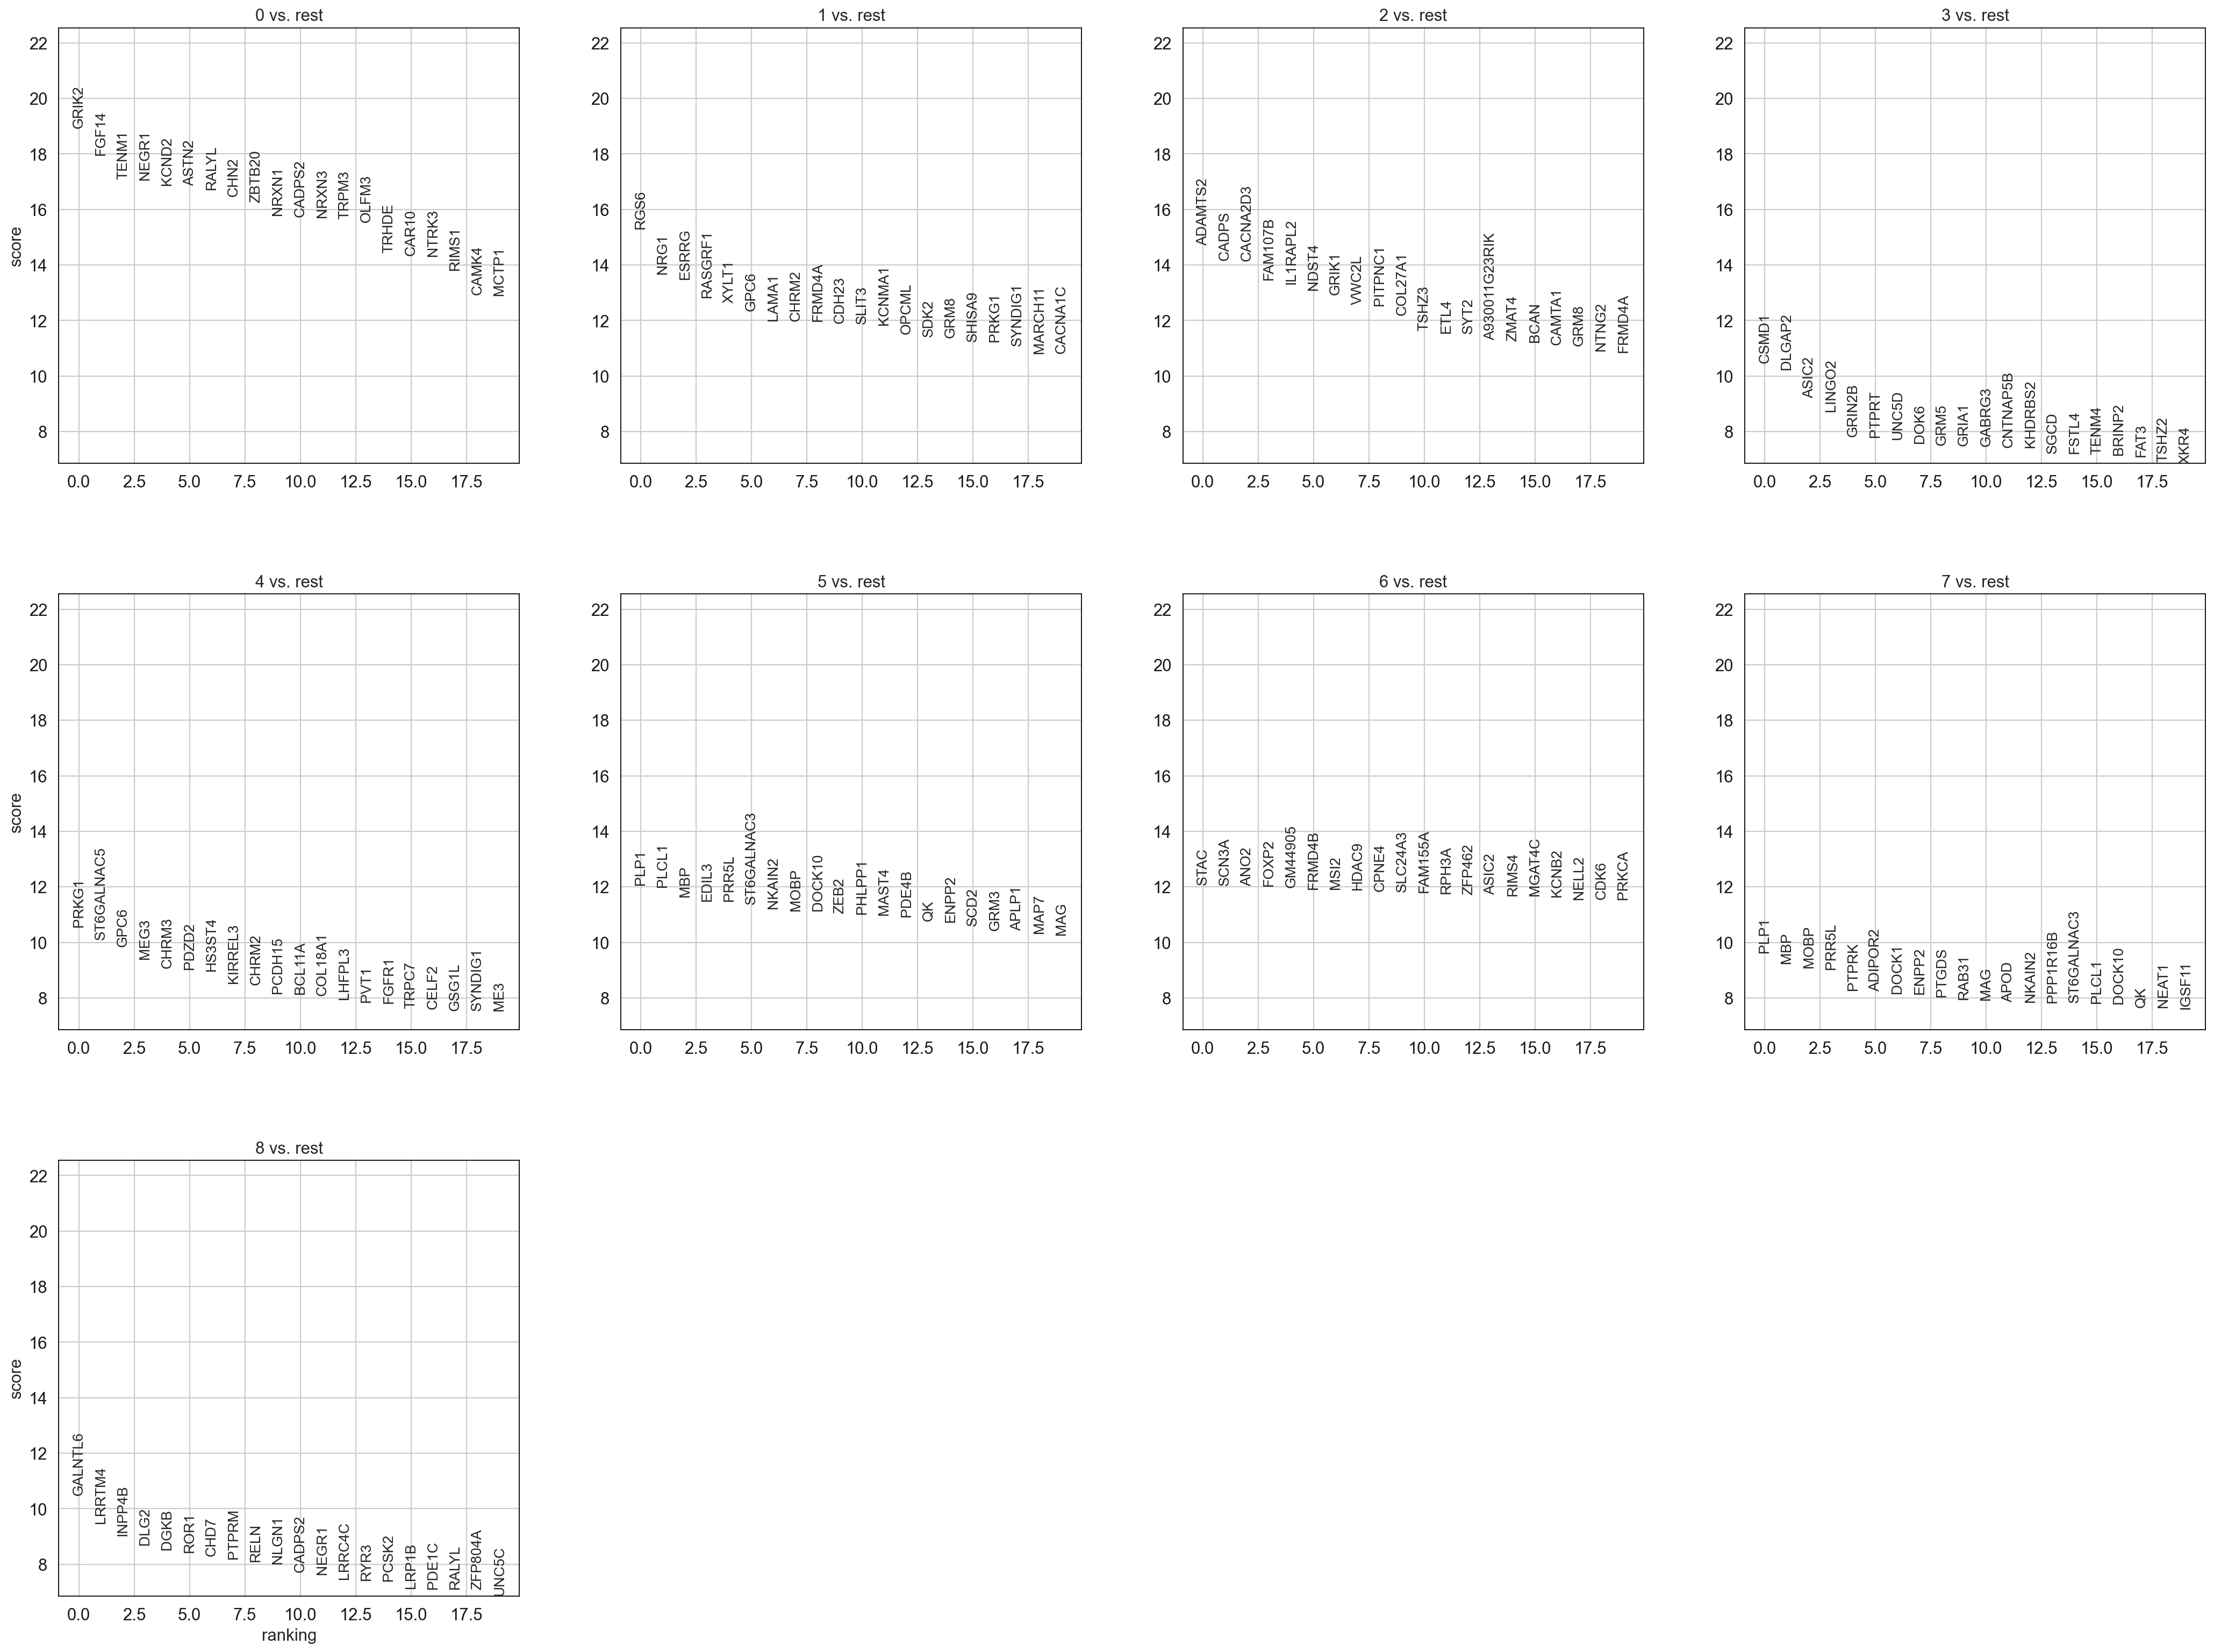

In [107]:
sc.tl.rank_genes_groups(adata_exci_BS, groupby='PhenoGraph_clusters_exci_BS', key_added="ranked_genes_pheno_exci", method='wilcoxon')
sc.pl.rank_genes_groups(adata_exci_BS, key = 'ranked_genes_pheno_exci', fontsize=12)

In [84]:
n_genes = 10000
key_ad ='ranked_genes_pheno_exci'
result = adata_exci_BS.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [85]:
#pval_table

In [ ]:
pval_table = pval_table.sort_values(by= 'group_0_1_3_4_6VE_l', ascending=False)
pval_table[(pval_table.group_0_1_3_4_6VE_p < 0.05) & (pval_table.group_0_1_3_4_6VE_l > 0.5)].head(10)

In [108]:
adata_exci_BS.obs.PhenoGraph_clusters_exci_BS.value_counts()

0    197
1    149
2    129
3     85
4     62
5     54
6     52
7     46
8     42
Name: PhenoGraph_clusters_exci_BS, dtype: int64

## Visualize marker genes using heatmap

In [109]:
adata_exci_BS.layers['scaled'] = sc.pp.scale(adata_exci_BS, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_exci_BS_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

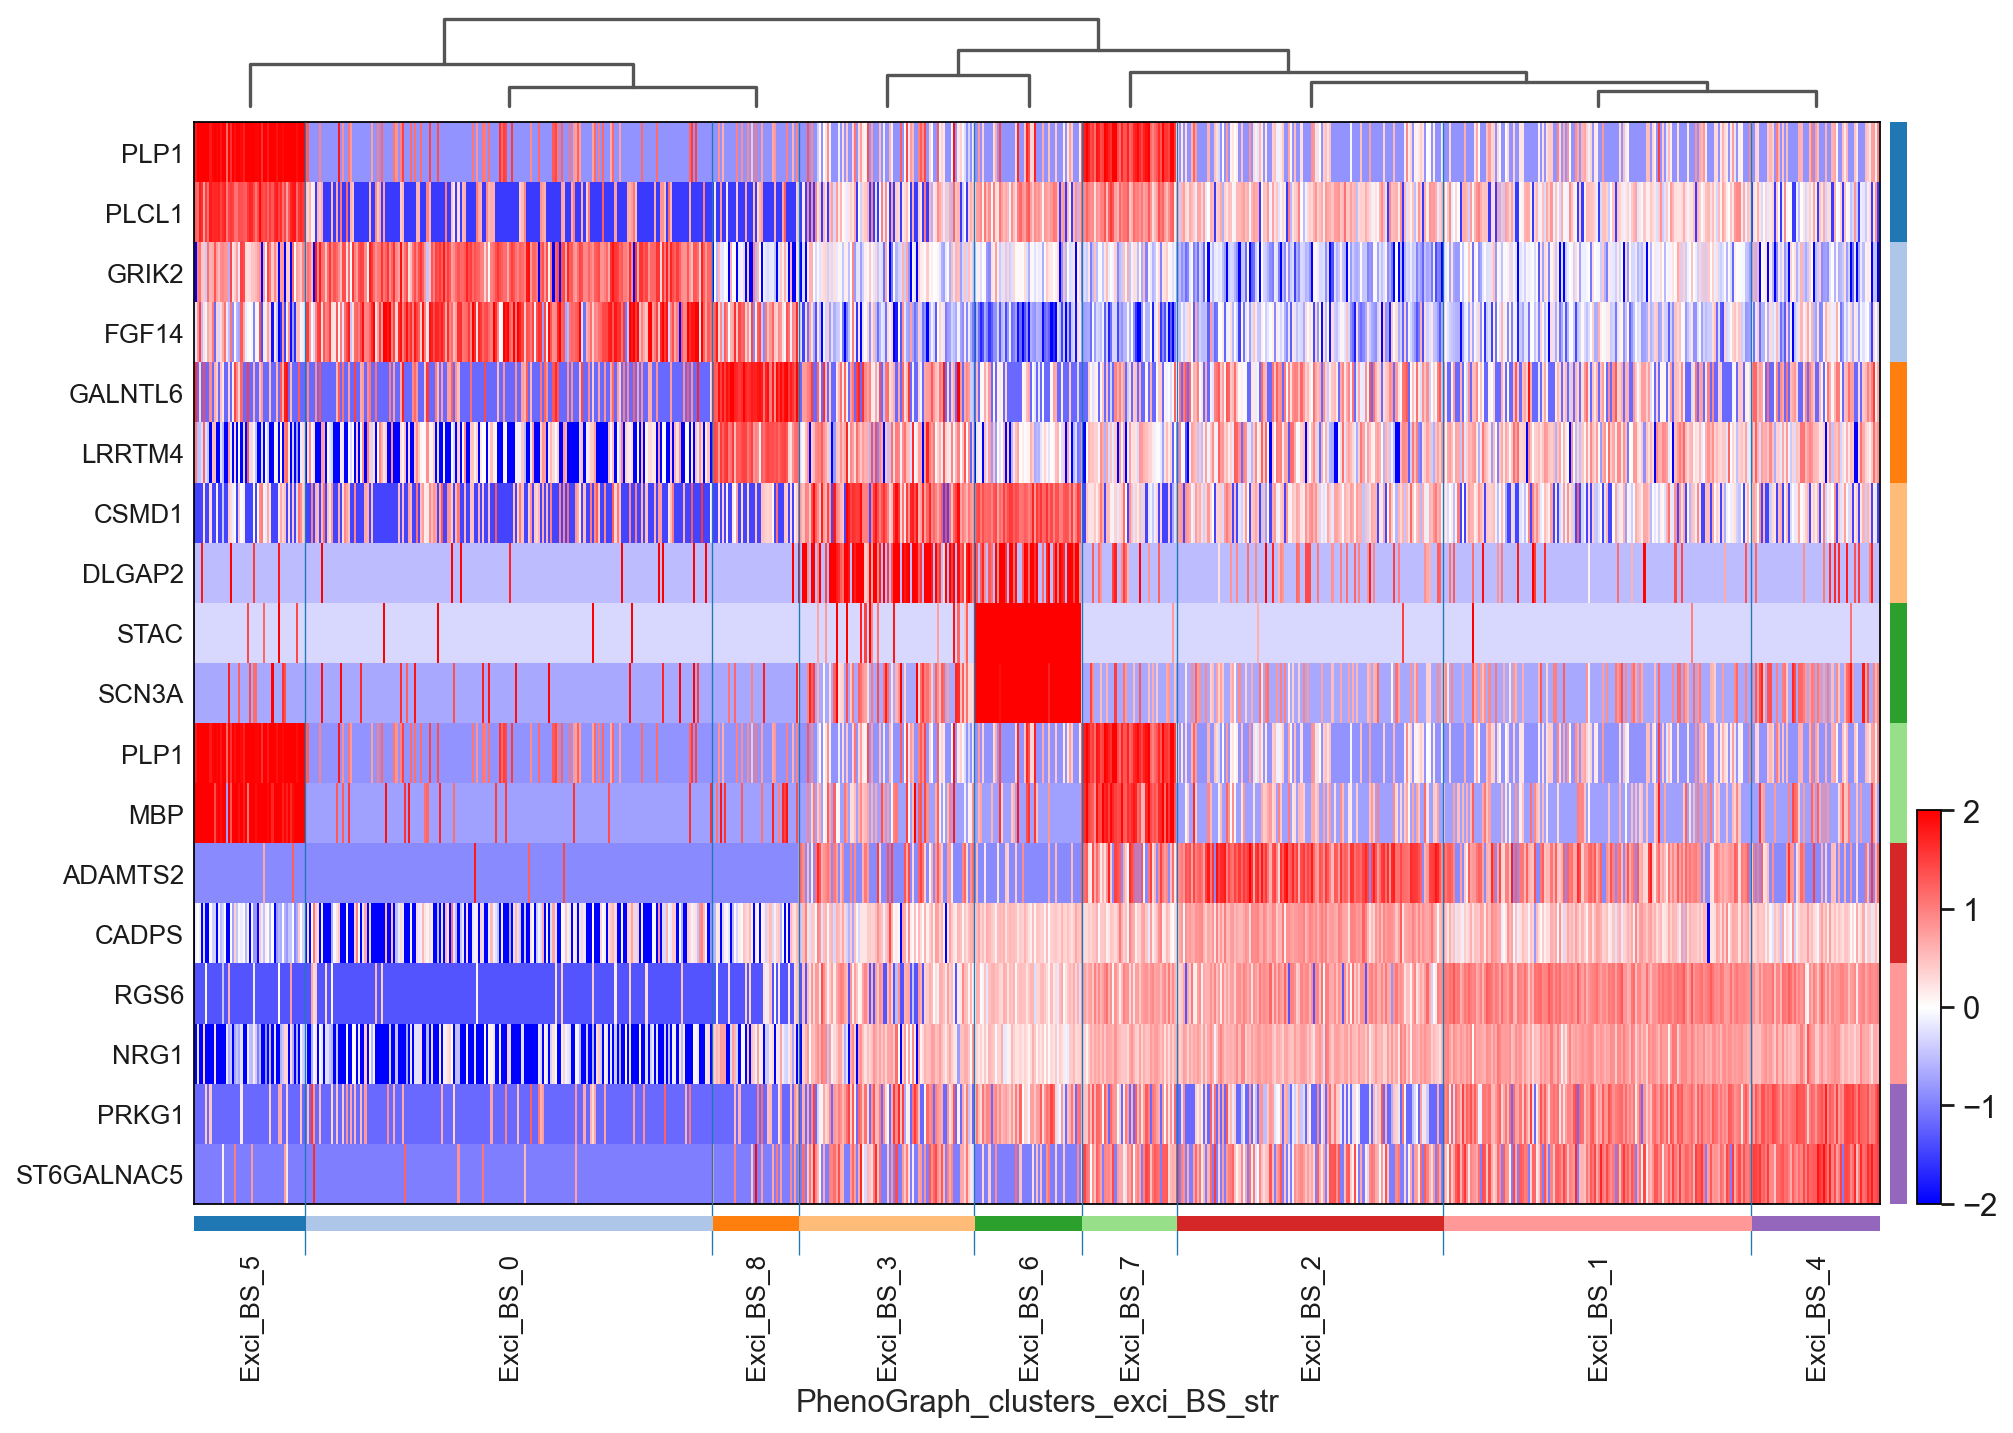

In [116]:
sc.tl.rank_genes_groups(adata_exci_BS, groupby='PhenoGraph_clusters_exci_BS_str', n_genes=adata_exci_BS.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_exci_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

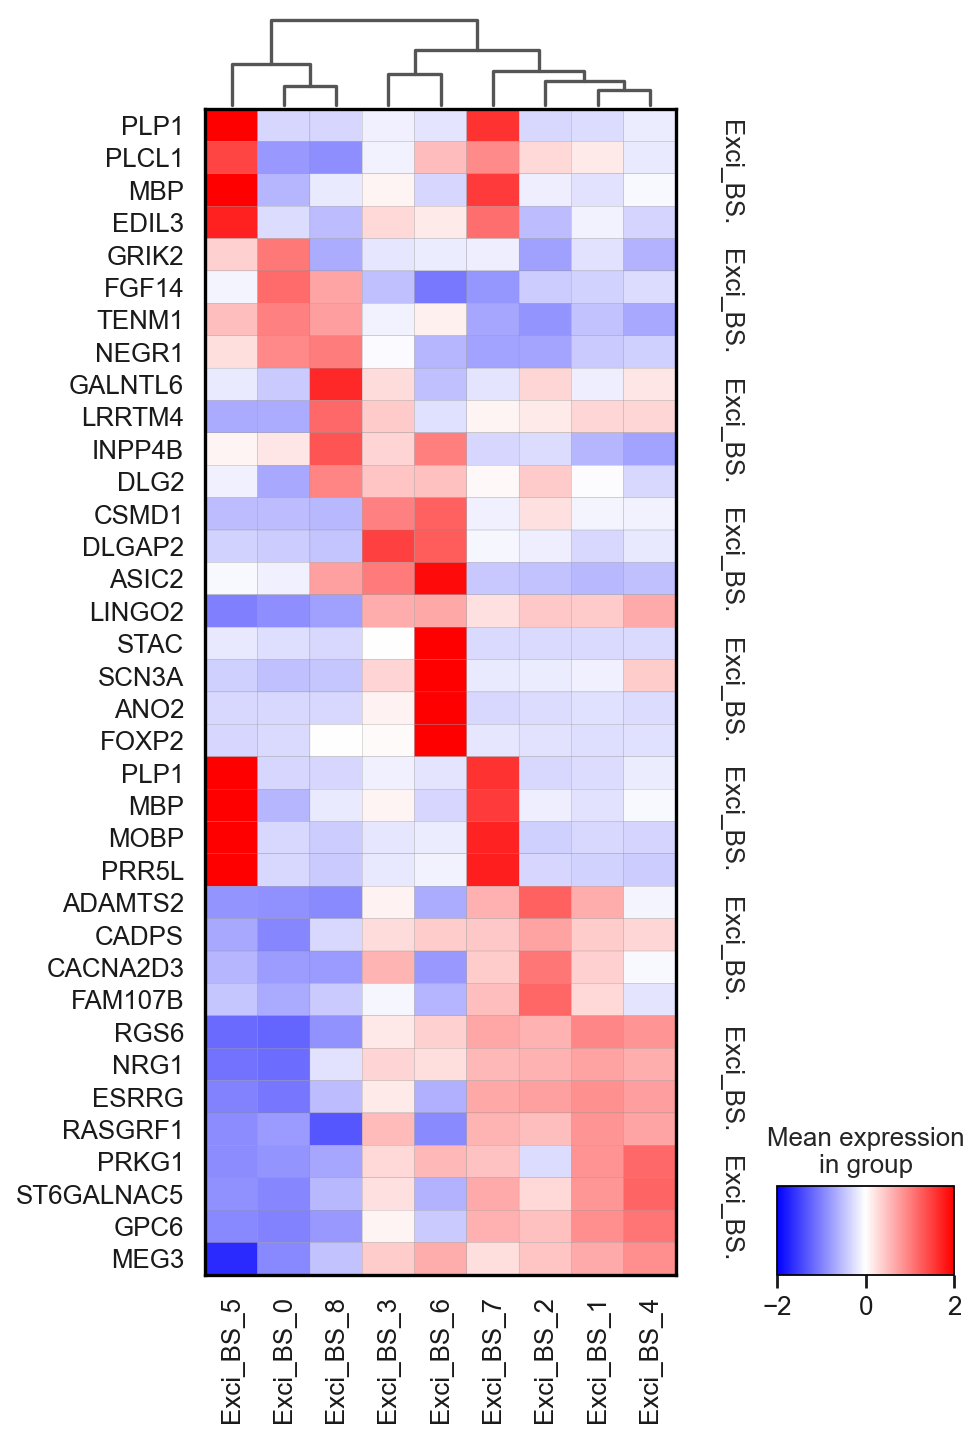

In [114]:
sc.pl.rank_genes_groups_matrixplot(adata_exci_BS, n_genes=4, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(6,10), show=False)

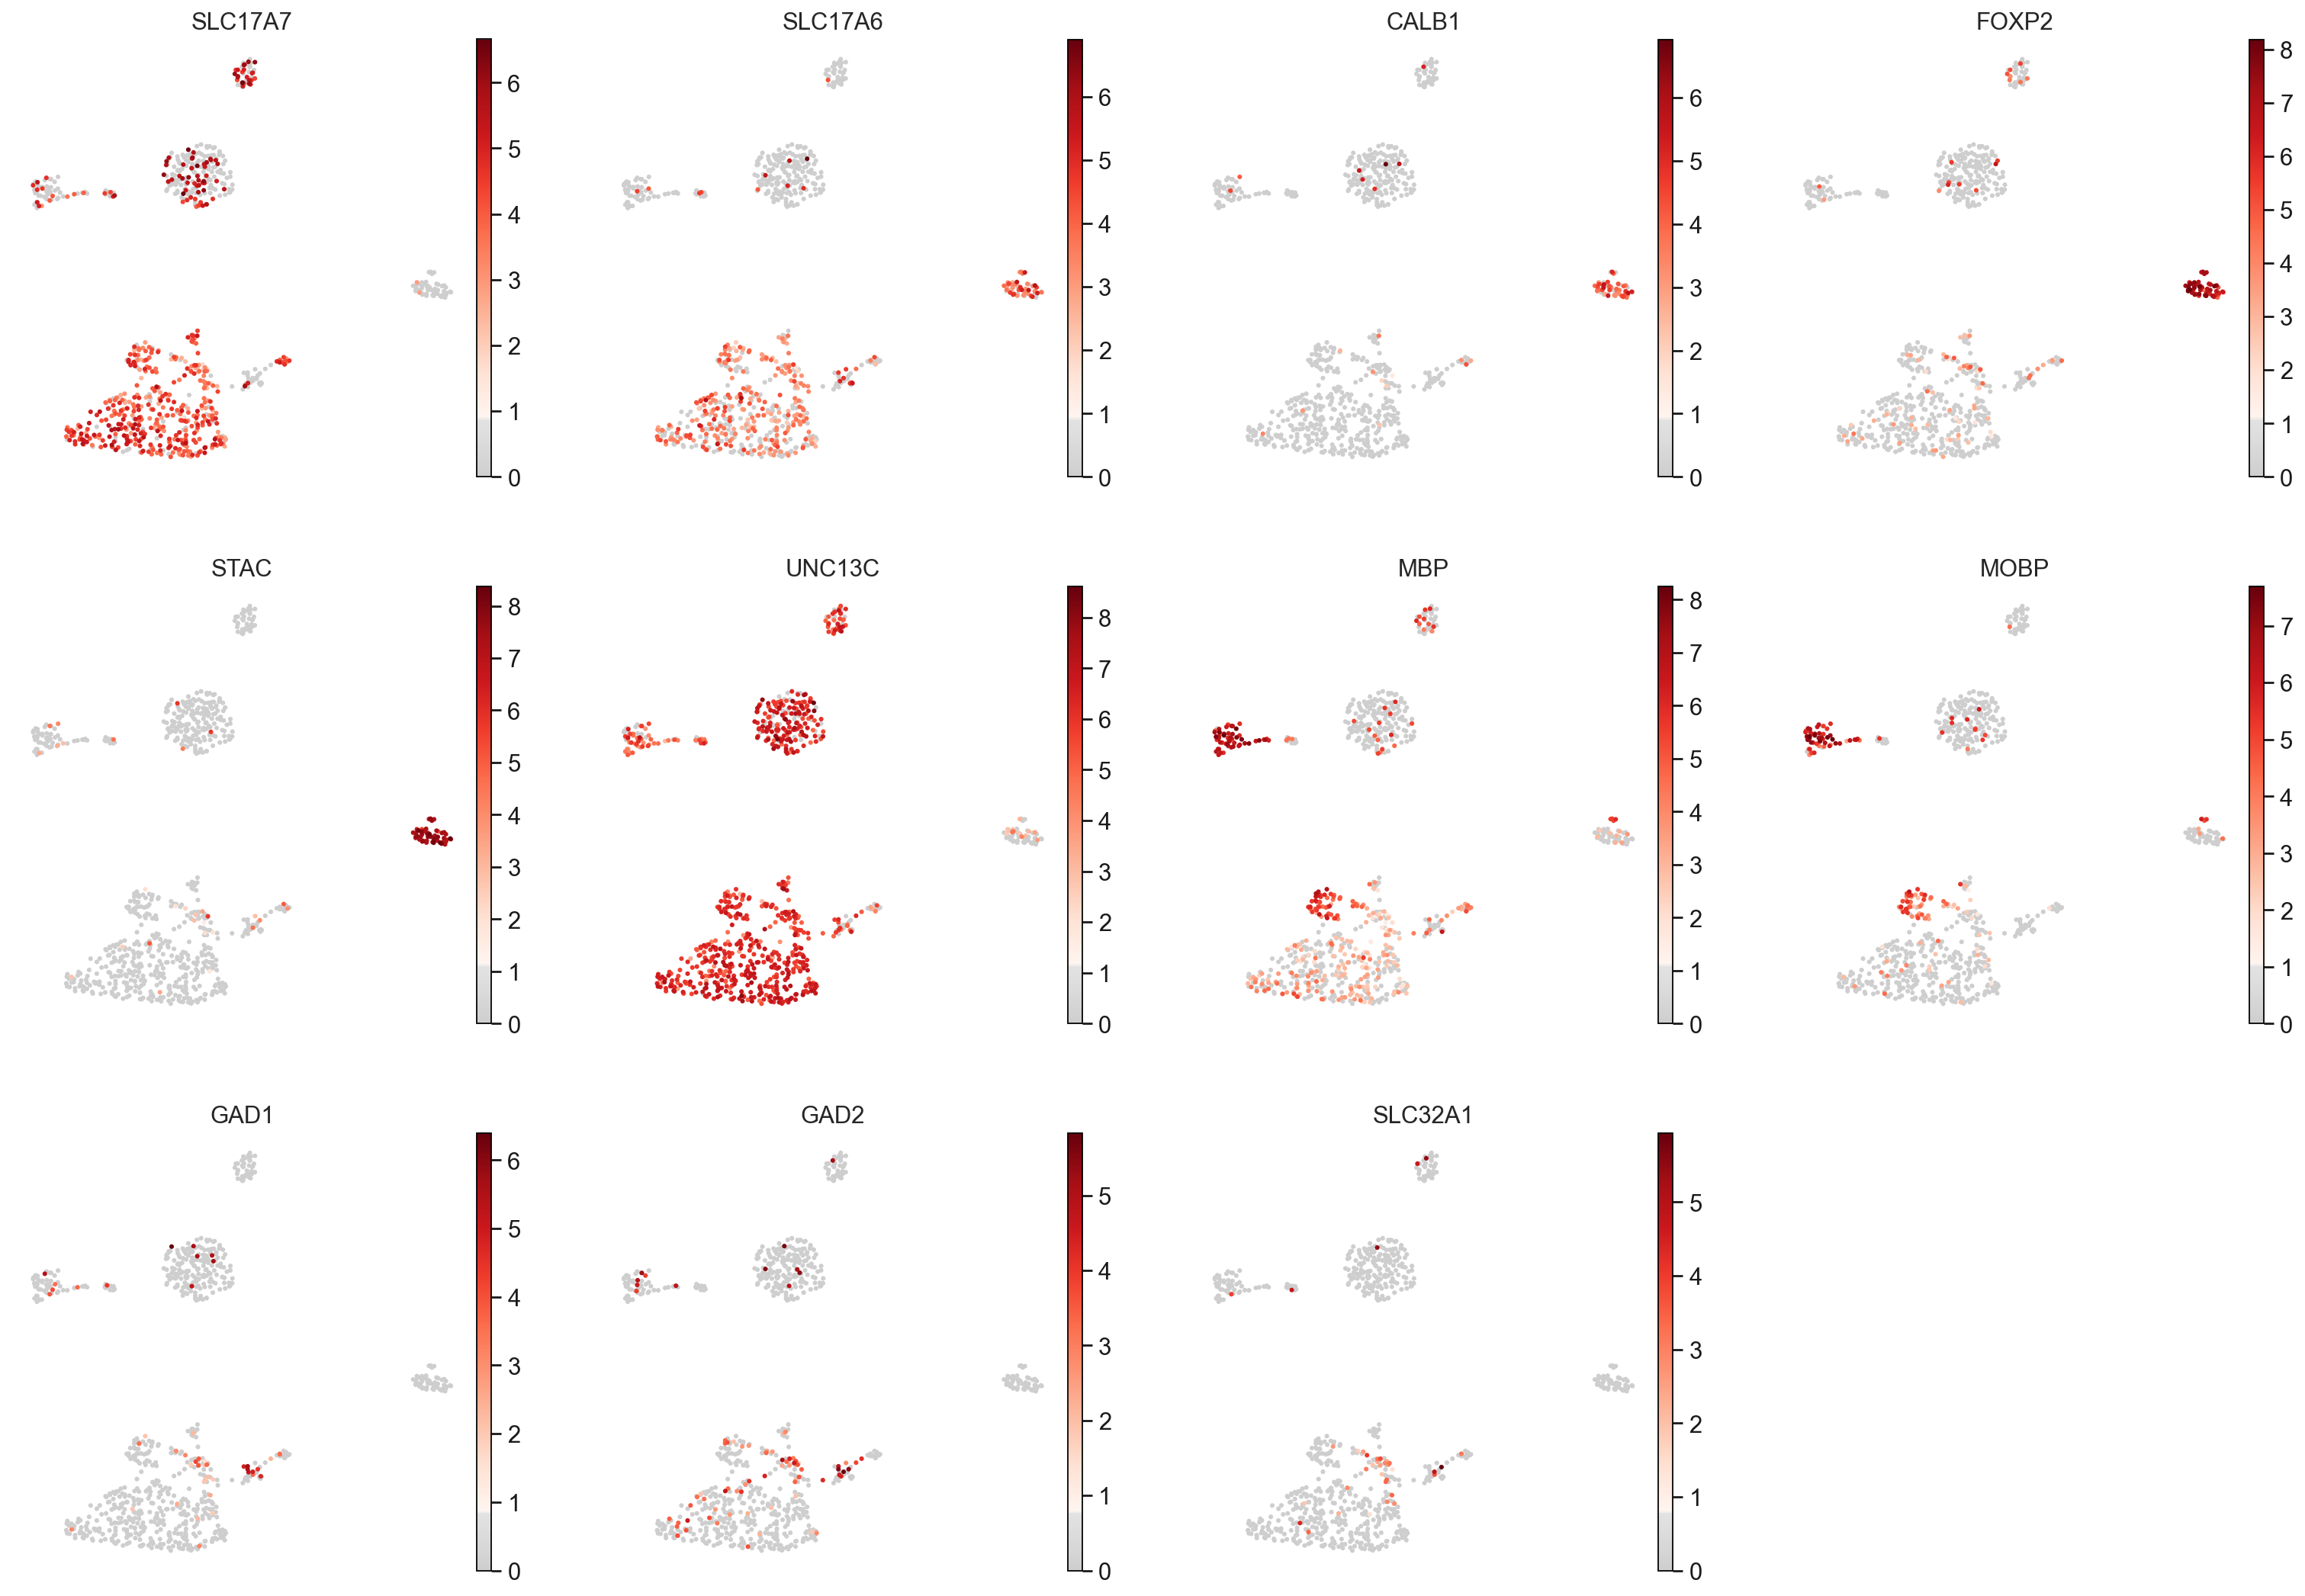

In [117]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_exci_BS,
           size = 30,
           color=['SLC17A7','SLC17A6','CALB1', 'FOXP2','STAC','UNC13C' , 'MBP','MOBP','GAD1','GAD2','SLC32A1'],
           color_map=mymap,
          frameon=False, )

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

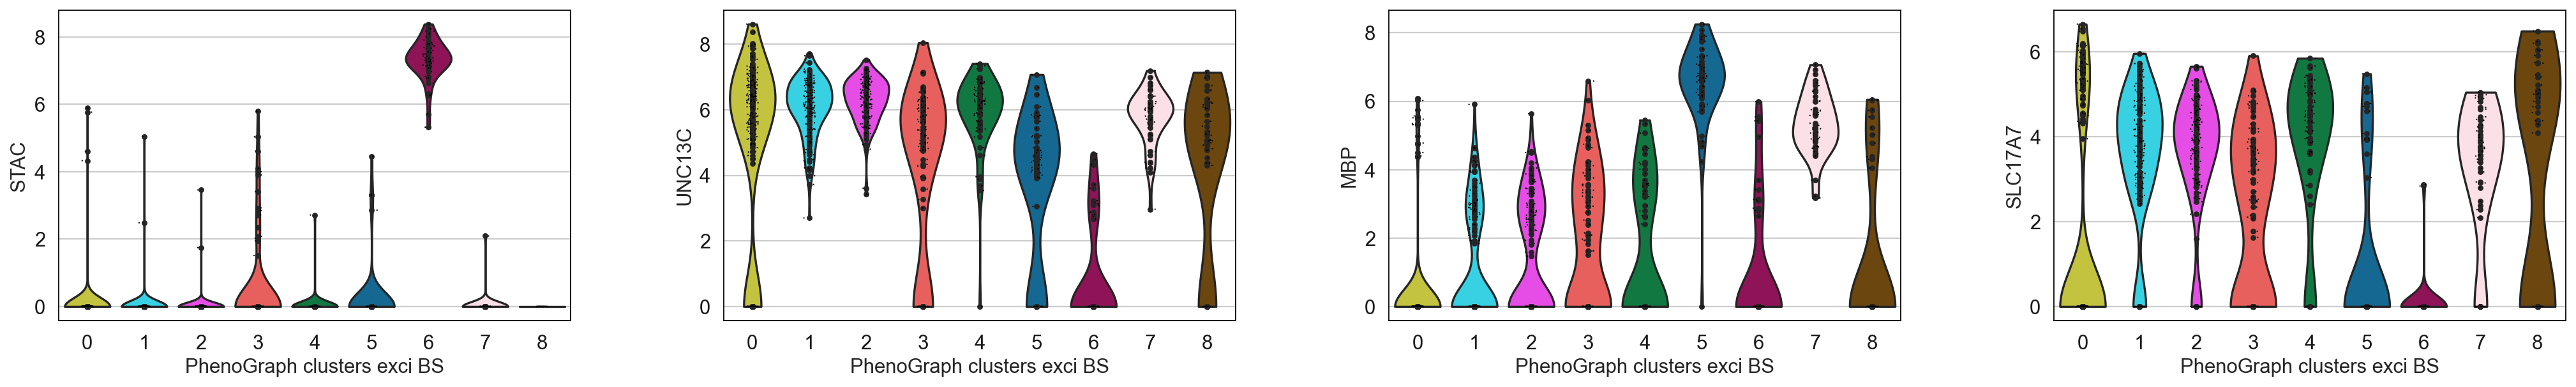

In [75]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_exci_BS, ['STAC','UNC13C','MBP','SLC17A7'], groupby='PhenoGraph_clusters_exci_BS', inner='point', palette = godsnot_64)

In [74]:
adata_exci_BS.obs.PhenoGraph_clusters_exci_BS.value_counts()

0    197
1    143
2    136
3     85
4     61
5     54
6     52
7     46
8     42
Name: PhenoGraph_clusters_exci_BS, dtype: int64

# Save result Adata Oligodendrocytes

In [115]:
#adata_exci_BS.write_h5ad(outdir+'adata_high_var_Excitatory_Neurons_Brainstem_clusters.h5ad')

Load the adata object that holds the latest cell type annotations..

In [79]:
adata_astro_BS = sc.read_h5ad(outdir+'adata_high_var_Excitatory_Neurons_Brainstem_clusters.h5ad')